# ADS 509 Module 3: Group Comparison 
## Ghassan Seba

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [2]:
# Use this space for any additional import statements you need
from contextlib import redirect_stdout
from matplotlib import pyplot as plt
import io


In [3]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of    
    """
    # Calculate the required values
    num_tokens = len(tokens)  
    num_unique_tokens = len(set(tokens))  # Cast as a set to remove duplicates
    lexical_diversity = num_unique_tokens / num_tokens if num_tokens > 0 else 0  # Avoid dividing by zero
    num_characters = sum(map(len, tokens))
    
    if verbose:
        print(f"\nThere are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        print()  # Add a blank line for spacing
    
        # print the five most common tokens
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

# Functions to analyze descriptive_stats' functions
def analyze_statistics(stats_column, group_by_column, df, stats=['min', 'max', 'mean', 'median']):
    
    # Create a DataFrame from the stats_column for analysis
    stats_df = pd.DataFrame(stats_column.tolist(), columns=['num_tokens', 'num_unique_tokens', 'lexical_diversity', 'num_characters'])

    # Combine with the group_by_column
    stats_df[group_by_column] = df[group_by_column].values

    # Calculate aggregated statistics for each metric
    lexical_diversity_stats = stats_df.groupby(group_by_column)['lexical_diversity'].agg(stats)
    num_tokens_stats = stats_df.groupby(group_by_column)['num_tokens'].agg(stats)
    unique_tokens_stats = stats_df.groupby(group_by_column)['num_unique_tokens'].agg(stats)
    characters_stats = stats_df.groupby(group_by_column)['num_characters'].agg(stats)

    # Display results with rounded values
    print(f'Statistics for Lexical Diversity by {group_by_column}:')
    print(lexical_diversity_stats.round(4))
    print(f'\nStatistics for Number of Tokens by {group_by_column}:')
    print(num_tokens_stats.round(4))
    print(f'\nStatistics for Number of Unique Tokens by {group_by_column}:')
    print(unique_tokens_stats.round(4))
    print(f'\nStatistics for Number of Characters by {group_by_column}:')
    print(characters_stats.round(4))

    # Return aggregated statistics
    return {
        'lexical_diversity_stats': lexical_diversity_stats,
        'num_tokens_stats': num_tokens_stats,
        'unique_tokens_stats': unique_tokens_stats,
        'characters_stats': characters_stats
    }


def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # Set of stopwords
    stop_words = set(stopwords.words('english'))
    # Remove stopwords
    cleaned_tokens = [word for word in tokens if word not in stop_words]
    return cleaned_tokens
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    # Define 'whitespace' using REGEX
    collapse_whitespace = re.compile(r'\s+')  
    return collapse_whitespace.split(text)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

# Function to read lyrics files 
def read_lyrics(folder):
    artist = os.path.basename(folder)  # Extract the folder name for artist name
    lyrics_data = []
    for filename in os.listdir(folder):
        with open(os.path.join(folder, filename), 'r', encoding='utf-8') as file:
            lyrics_entry = file.read()
            lyrics_data.append({"artist": artist, "lyrics_entry": lyrics_entry})  # Append artist and lyrics
    return lyrics_data

# Function to extract artist, song title, and lyrics
def parse_lyrics(lyrics_entry, artist):
    
    # Separate the song title from the lyrics
    song_title, song_lyrics = lyrics_entry.split('\n\n\n\n', 1)
    
    # Return a dictionary with the parsed data
    return {"artist": artist, "song_title": song_title, "song_lyrics": song_lyrics}

# Function to read Twitter data and add 'artist' column
def read_followers_data(file_path, artist_name):
    df = pd.read_csv(file_path, delimiter='\t', quotechar='"', engine='python', on_bad_lines='skip')
    df['artist'] = artist_name
    # Reorder columns to make 'Artist' the first column
    df = df[['artist'] + [col for col in df.columns if col != 'artist']]
    return df



## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

### Read in Lyrics and Twitter data and Convert to Data Frame

In [4]:
# Define lyrics folder
lyrics_folder = "./lyrics"

# read in the lyrics here
cher_lyrics = read_lyrics(os.path.join(lyrics_folder, "cher"))
robyn_lyrics = read_lyrics(os.path.join(lyrics_folder, "robyn"))

# Combine both lists of
all_lyrics = cher_lyrics + robyn_lyrics

# Apply the function and create a list of dictionaries
parsed_lyrics = [parse_lyrics(entry['lyrics_entry'], entry['artist']) for entry in all_lyrics]

# Convert the list of dictionaries into a DataFrame
lyrics_combined = pd.DataFrame(parsed_lyrics)

# Display the DataFrame
lyrics_combined.head()

,artist,song_title,song_lyrics
0,cher,"""88 Degrees""","Stuck in L.A., ain't got no friends \nAnd so H..."
1,cher,"""A Different Kind Of Love Song""",What if the world was crazy and I was sane\nWo...
2,cher,"""After All""","Well, here we are again\nI guess it must be fa..."
3,cher,"""Again""",Again evening finds me at your door \nHere to ...
4,cher,"""Alfie""","What's it all about, Alfie?\nIs it just for th..."


In [5]:
# File paths
cher_file_path = './twitter/cher_followers_data.txt'
robyn_file_path = './twitter/robynkonichiwa_followers_data.txt'

# Read data
cher_data = read_followers_data(cher_file_path, 'Cher')
robyn_data = read_followers_data(robyn_file_path, 'Robyn')

# Combine DataFrames
twitter_combined = pd.concat([cher_data, robyn_data], ignore_index=True)

# Show combined data
twitter_combined.head()

,artist,screen_name,name,id,location,followers_count,friends_count,description
0,Cher,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN
1,Cher,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜
2,Cher,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡
3,Cher,gallionjenna,J,3366479914,NaN,752,556,csu
4,Cher,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [6]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

# Create a copy of the DataFrames
lyrics_data = lyrics_combined.copy()
twitter_data = twitter_combined.copy()

# Remove the 'song_title' column from the  DataFrame 
lyrics_data = lyrics_data.drop(columns=['song_title'])

lyrics_data["tokens"] = lyrics_data["song_lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 


In [7]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [8]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
120207,Cher,Listen... Stand-up comedian 🎙 Elaborate sneake...,"[listen, standup, comedian, 🎙, elaborate, snea..."
1417564,Cher,"Long term emo, mother. Tea connoisseur. fibro ✌🏻","[long, term, emo, mother, tea, connoisseur, fi..."
2075183,Cher,"V 2.0 Modi Sarkar!! Sabka Saath, Sabka vikas, ...","[v, 20, modi, sarkar, sabka, saath, sabka, vik..."
2436397,Cher,#TeamMMA4LIFE #NoBulling #NotoriousNation #LUF...,"[#teammma4life, #nobulling, #notoriousnation, ..."
2270942,Cher,"Taurino SIM ♉, gado NUNCA!!! 🐂🚫 PS. Sou legal,...","[taurino, sim, ♉, gado, nunca, 🐂🚫, ps, sou, le..."
2525137,Cher,Kaylaaa .. I love my friends&family .. John Ma...,"[kaylaaa, love, friendsfamily, john, mayer❤️]"
3601018,Cher,living life to the full ❤,"[living, life, full, ❤]"
2998646,Cher,♥♥♥,[♥♥♥]
3717424,Cher,♎️💫,[♎️💫]
858946,Cher,• #T1D •Teacher• Dad of twins ❤️👨‍👨‍👧‍👦,"[•, #t1d, •teacher•, dad, twins, ❤️👨‍👨‍👧‍👦]"


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

***A: One area of improvement could be handling non-English text by either translating it into English or removing it if the focus is on English content. Also, lemmatization can be used to convert words to their base forms (e.g., "running" to "run") while maintaining context.*** 

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [9]:
# Display lyrics_data DF
lyrics_data.head()

,artist,song_lyrics,tokens,num_tokens
0,cher,"Stuck in L.A., ain't got no friends \nAnd so H...","[stuck, la, aint, got, friends, hollywood, nut...",181
1,cher,What if the world was crazy and I was sane\nWo...,"[world, crazy, sane, would, strange, cant, bel...",134
2,cher,"Well, here we are again\nI guess it must be fa...","[well, guess, must, fate, weve, tried, deep, i...",121
3,cher,Again evening finds me at your door \nHere to ...,"[evening, finds, door, ask, could, try, dont, ...",35
4,cher,"What's it all about, Alfie?\nIs it just for th...","[whats, alfie, moment, live, whats, sort, alfi...",67


In [10]:
# Apply descriptive_stats to the 'tokens' column and Suppress output from function
with redirect_stdout(io.StringIO()):
    lyrics_data['token_stats'] = lyrics_data['tokens'].apply(descriptive_stats)

In [11]:
# Analyze token-level statistics by artist
token_stats_analysis = analyze_statistics(lyrics_data['token_stats'], 'artist', lyrics_data)

Statistics for Lexical Diversity by artist:
           min     max    mean  median
artist                                
cher    0.2261  0.9167  0.5397  0.5326
robyn   0.1561  1.0000  0.4814  0.4593

Statistics for Number of Tokens by artist:
        min  max      mean  median
artist                            
cher     21  241  112.4968   108.5
robyn     9  351  145.6250   137.0

Statistics for Number of Unique Tokens by artist:
        min  max     mean  median
artist                           
cher      9  129  58.2437    57.5
robyn     9  183  64.0385    60.0

Statistics for Number of Characters by artist:
        min   max      mean  median
artist                             
cher    127  1234  535.5823   501.5
robyn    56  1624  700.0385   642.0


Q: what observations do you make about these data? 

***A: The tables above show that Cher's songs have a slightly higher average lexical diversity (0.5397) compared to Robyn's (0.4814), though Robyn's maximum reaches 1. Robyn's songs tend to be longer, with a higher average number of tokens (145.63 vs. 112.50) and characters (700.04 vs. 535.58). Both artists have similar ranges for unique tokens, though Robyn's songs reach a higher maximum. I would presume, based on their mean/median lexical diversity and number of unique tokens, that they are pop artists writing songs that appeal to a broader audience.***


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [13]:
# Total tokens for each artist
total_tokens_cher = lyrics_data[lyrics_data['artist'] == 'cher']['num_tokens'].sum()
total_tokens_robyn = lyrics_data[lyrics_data['artist'] == 'robyn']['num_tokens'].sum()

# Combined tokens for each artist
tokens_cher = [token for sublist in lyrics_data[lyrics_data['artist'] == 'cher']['tokens'] for token in sublist]
tokens_robyn = [token for sublist in lyrics_data[lyrics_data['artist'] == 'robyn']['tokens'] for token in sublist]

# Token counts
count_cher = Counter(tokens_cher)
count_robyn = Counter(tokens_robyn)

# Cutoff filter
cutoff = 5

# DataFrame with token counts and concentrations
tokens = set(count_cher.keys()).union(set(count_robyn.keys()))
token_df = pd.DataFrame(tokens, columns=['token'])
token_df['count_cher'] = token_df['token'].map(count_cher).fillna(0).astype(int)
token_df['count_robyn'] = token_df['token'].map(count_robyn).fillna(0).astype(int)
token_df['concent_cher'] = token_df['count_cher'] / total_tokens_cher
token_df['concent_robyn'] = token_df['count_robyn'] / total_tokens_robyn

# Concentration ratios for Cher and Robyn
token_df['concent_ratio_cher'] = token_df.apply(
    lambda row: row['concent_cher'] / row['concent_robyn'] if row['concent_robyn'] > 0 else float('inf'), axis=1
)
token_df['concent_ratio_robyn'] = token_df.apply(
    lambda row: row['concent_robyn'] / row['concent_cher'] if row['concent_cher'] > 0 else float('inf'), axis=1
)

# Cutoff filter
token_df['passes_cutoff'] = (token_df['count_cher'] >= cutoff) & (token_df['count_robyn'] >= cutoff)
filtered_tokens = token_df[token_df['passes_cutoff']]

# Rounding to 4 decimal places
filtered_tokens.loc[:, ['concent_cher', 'concent_robyn', 'concent_ratio_cher', 'concent_ratio_robyn']] = filtered_tokens[
    ['concent_cher', 'concent_robyn', 'concent_ratio_cher', 'concent_ratio_robyn']].round(4)

# Top 10 unique tokens for each artist
top_10_cher = filtered_tokens.sort_values(by='concent_ratio_cher', ascending=False).head(10)
top_10_robyn = filtered_tokens.sort_values(by='concent_ratio_robyn', ascending=False).head(10)

In [14]:
# Display results for Cher
print("Top 10 unique tokens for Cher:")
top_10_cher[['token', 'count_cher', 'count_robyn', 'concent_cher', 'concent_robyn', 'concent_ratio_cher']]

Top 10 unique tokens for Cher:


,token,count_cher,count_robyn,concent_cher,concent_robyn,concent_ratio_cher
2832,walk,114,5,0.0032,0.0003,9.7135
2187,find,135,6,0.0038,0.0004,9.5857
4067,enough,124,7,0.0035,0.0005,7.5468
1405,without,84,5,0.0024,0.0003,7.1573
453,man,201,12,0.0057,0.0008,7.1360
2129,strong,76,5,0.0021,0.0003,6.4757
691,live,68,5,0.0019,0.0003,5.7940
3127,believe,139,11,0.0039,0.0007,5.3835
1533,tears,56,5,0.0016,0.0003,4.7716
2388,well,163,16,0.0046,0.0011,4.3402


In [15]:
# Display results for Robyn
print("\nTop 10 unique tokens for Robyn:")
top_10_robyn[['token', 'count_cher', 'count_robyn', 'concent_cher', 'concent_robyn', 'concent_ratio_robyn']]


Top 10 unique tokens for Robyn:


,token,count_cher,count_robyn,concent_cher,concent_robyn,concent_ratio_robyn
1669,beat,17,144,0.0005,0.0095,19.8825
3763,dance,25,148,0.0007,0.0098,13.8957
2606,work,15,75,0.0004,0.0050,11.7362
2453,hang,8,35,0.0002,0.0023,10.2692
2476,shake,6,18,0.0002,0.0012,7.0417
3803,forgive,5,15,0.0001,0.0010,7.0417
3107,alright,10,30,0.0003,0.0020,7.0417
2829,party,8,21,0.0002,0.0014,6.1615
4448,88,5,13,0.0001,0.0009,6.1028
500,pretend,6,15,0.0002,0.0010,5.8681


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

***A: Cher's top tokens include words like "walk," "find," "enough," "strong," and "tears," showing the common themes in her lyrics tend toward more introspective topics. Robyn's top tokens, i.e., "beat," "dance," "work," "party," and "shake," seem to indicate her writing style focuses on energetic, dance-related material. Given our earlier presumption that these are pop artists, we might be able to presume from this analysis that Cher targets a slightly older audience with more life experiences, while Robyn's songs are meant to appeal to a younger audience looking for lighthearted, lively content.***

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [16]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "blue", colormap="Reds", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)

    # Plot the wordcloud
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Combine tokens for specified artist and calculate frequency
def create_word_frequencies(data, artist):
    tokens = [token for sublist in data[data['artist'] == artist]['tokens'] for token in sublist]
    return Counter(tokens)
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

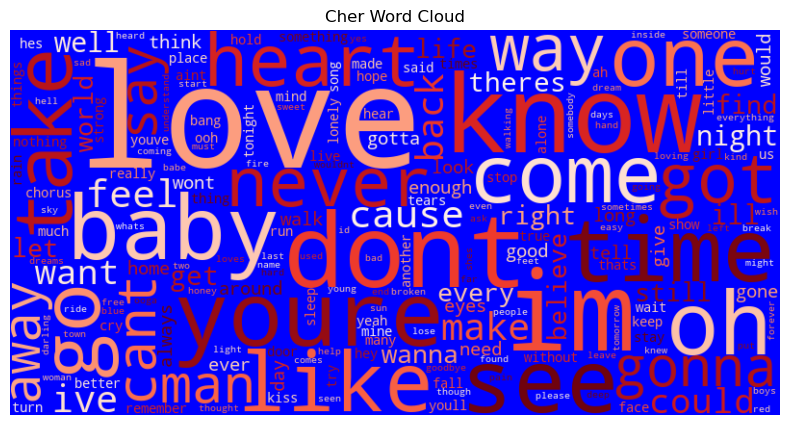

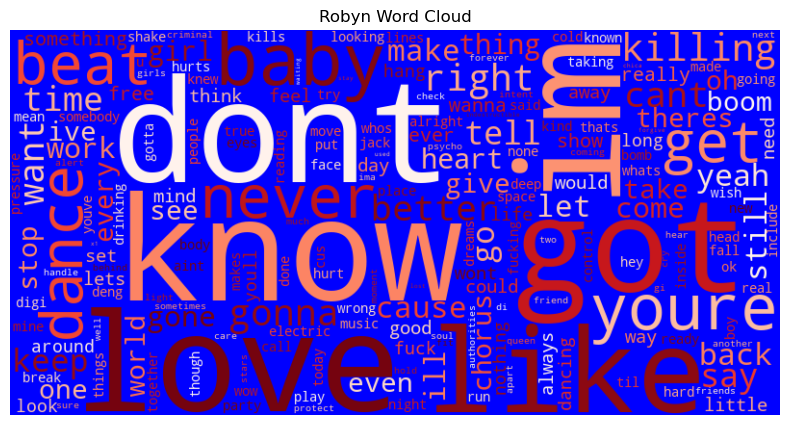

In [17]:
# Create frequency dictionaries for each artist
cher_word_freq = create_word_frequencies(lyrics_data, 'cher')
robyn_word_freq = create_word_frequencies(lyrics_data, 'robyn')

# Generate word clouds
wordcloud(cher_word_freq, title="Cher Word Cloud")
wordcloud(robyn_word_freq, title="Robyn Word Cloud")

Q: What observations do you have about these (relatively straightforward) wordclouds? 

***A: Both artists' word clouds contain similar high-frequency words, like "Baby," "Like," "Don't," "Got," "Love," and "Know," despite the different audiences they may cater to. Perhaps they are using similar phrases or expressions in their songs but in distinct ways.*** 

<center><b>References:</b></center>

- Albrecht, J., Ramachandran, S., & Winkler, C. (2020). *Blueprints for text analytics using Python.* O'Reilly.
- S, M., & Pieters, M. (2018, October 29). *How to get length of all the tokens of all the list for a given input file in python?.* Stack Overflow. https://stackoverflow.com/questions/53050095/how-to-get-length-of-all-the-tokens-of-all-the-list-for-a-given-input-file-in-py
- Mayer , C. (2023, December 14). *How to Open Multiple Text Files in Python (6 Best Methods).* Be on the Right Side of Change. https://blog.finxter.com/how-to-open-multiple-text-files-in-python-6-best-methods/
- Python Software Foundation. (n.d.). *os.path — Common pathname manipulations.* Python documentation. https://docs.python.org/3/library/os.path.html
- Python Software Foundation. (n.d.). *The with statement. Python 3.11.5 documentation.* https://docs.python.org/3/reference/compound_stmts.html#the-with-statement
- Sharma, P. (2021, June 18). *How to read multiple text files from a folder in python?(tkinter).* Tutorialspoint. https://www.tutorialspoint.com/how-to-read-multiple-text-files-from-a-folder-in-python-tkinter
- Willems, K. (2020, January 2). *Python functions: How to call & write functions.* DataCamp. https://www.datacamp.com/tutorial/functions-python-tutorial
- GeeksforGeeks. (2024a, March 20). *Python most_common() function.* https://www.geeksforgeeks.org/python-most_common-function/ 
- Chris, K. (2022, March 16). *Python functions – how to define and call a function.* freeCodeCamp.org. https://www.freecodecamp.org/news/python-functions-define-and-call-a-function/
- GeeksforGeeks. (2023, September 27). *Split and parse a string in Python.* https://www.geeksforgeeks.org/split-and-parse-a-string-in-python/
- Python Software Foundation. (n.d.). *Text sequence type — str. Python Documentation.* https://docs.python.org/3/library/stdtypes.html#str.split
- GeeksforGeeks. (2024, August 21). *Python: Os.path.basename() method.* https://www.geeksforgeeks.org/python-os-path-basename-method/
- Hodgkinson, L. (2020, December 30). *NLP pipelines with NLTK.* Lee’s Notebook. https://lee-hodg.github.io/blog/nlp/
- Fuchs, M. (2021, May 25). *NLP - text pre-processing II (tokenization and stop words)* - Michael Fuchs Python. MFuchs. https://michael-fuchs-python.netlify.app/2021/05/25/nlp-text-pre-processing-ii-tokenization-and-stop-words/
- GeeksforGeeks. (2024, January 3). *Removing stop words with NLTK in python.* GeeksforGeeks. https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
- Pandas Documentation. (n.d.). pandas.DataFrame.isna. Pandas. Retrieved September 15, 2024, from https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isna.html
- Singh, P. (2023, March 31). *How to remove punctuation from Python string?* - shiksha online. Study in India. https://www.shiksha.com/online-courses/articles/how-to-remove-punctuation-from-python-string/#:~:text=down%20the%20process.-,Using%20translate(),character%20or%20delete%20them%20altogether.
- Solomon, B. (2023, July 31). *Pandas GroupBy: Your guide to grouping data in python.* Real Python. https://realpython.com/pandas-groupby/
- Ogunbiyi, I. A. (2022, October 25). *How the Python Lambda Function Works – explained with examples.* freeCodeCamp.org. https://www.freecodecamp.org/news/python-lambda-function-explained/
- GeeksforGeeks. (2024a, August 9). *Applying lambda functions to pandas dataframe.* https://www.geeksforgeeks.org/applying-lambda-functions-to-pandas-dataframe/ 
- OpenAI. (2023). ChatGPT (September 9 version) [Large language model]. https://chat.openai.com/
- Cloud, S. (2024, January 11). *How to remove special characters in pandas dataframe.* Saturn Cloud Blog. https://saturncloud.io/blog/how-to-remove-special-characters-in-pandas-dataframe/
- Orozco, F. (2018, March 22). *Suppress print output in Python.* coding(dose). https://codingdose.info/posts/supress-print-output-in-python/
- GeeksforGeeks. (2020, December 2). *Flatten a list of DataFrames. GeeksforGeeks.* https://www.geeksforgeeks.org/flatten-a-list-of-dataframes/
- GeeksforGeeks. (2023, December 27). *Python infinity (inf).* GeeksforGeeks. https://www.geeksforgeeks.org/python-infinity-inf/
- Bobbitt, Z. (2022, June 23). *How (and why) to make copy of pandas DataFrame.* Statology. https://www.statology.org/how-and-why-to-make-copy-of-pandas-dataframe/
- GeeksforGeeks. (2023, February 20). *Find frequency of each word in a string in Python.* GeeksforGeeks. https://www.geeksforgeeks.org/find-frequency-of-each-word-in-a-string-in-python/